In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

# Challenge: Iterate & Evaluate Your Classifier

In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

%matplotlib inline

data_path = ('sentiments/amazon_cells_labelled.txt')
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['text', 'Positive']

df.head()

,text,Positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [3]:
all_words = []

def clean_sentence_and_get_words(row):
    sentence = row[1]['text'].lower()
    sentence = re.sub("[^a-zA-Z' ]+", " ", sentence)
    return sentence.split()
    
for row in df.iterrows():
    words = clean_sentence_and_get_words(row);
    for word in words:
        if len(word) > 0:
            all_words.append(word)

counts = Counter(all_words)
keywords = [k for k, v in counts.items() if v > 15]

counts.most_common(15)

[('the', 519),
 ('i', 326),
 ('and', 311),
 ('it', 284),
 ('is', 243),
 ('a', 221),
 ('this', 208),
 ('to', 197),
 ('phone', 165),
 ('my', 145),
 ('for', 121),
 ('of', 120),
 ('not', 117),
 ('with', 112),
 ('very', 104)]

In [4]:
common_words = ['a', 'about', 'all', 'also', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'by', 'can', 'did', 'do', 'does', 'even', 'for', 'from', 'get', 'had', 'has', 'have', 'having', 'i', "if", "i'm", "i've", 'in', 'is', 'it', 'item', "it's", 'its', 'me', 'my', 'of', 'on', 'one', 'or', 'than', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'will', 'with', 'within', 'you', 'your']
domain_specific_words = ['amazon', 'audio', 'batteries', 'battery', 'bluetooth', 'buttons', 'camera', 'car', 'cars', 'case', 'charger', 'device', 'ear', 'ears', 'earset', 'headphones', 'headset', 'jabra', 'jawbone', 'motorola', 'nokia', 'phone', 'plug', 'samsung', 'software', 'sound', 'verizon']
all_important_words = []

for row in df.iterrows():
    words = clean_sentence_and_get_words(row);
    for word in words:
        if len(word) > 0 and word not in common_words and word not in domain_specific_words:
            all_important_words.append(word)

counts = Counter(all_important_words)
keywords = [k for k, v in counts.items() if v > 15]

counts.most_common(25)

[('not', 117),
 ('very', 104),
 ('great', 99),
 ('good', 78),
 ('product', 55),
 ('quality', 49),
 ('works', 47),
 ('but', 46),
 ('so', 42),
 ('well', 42),
 ('use', 41),
 ('would', 34),
 ('work', 34),
 ('like', 31),
 ("don't", 28),
 ('no', 27),
 ('excellent', 27),
 ('up', 27),
 ('time', 27),
 ('after', 27),
 ('price', 27),
 ('recommend', 26),
 ('really', 26),
 ('best', 23),
 ('out', 23)]

## Baseline

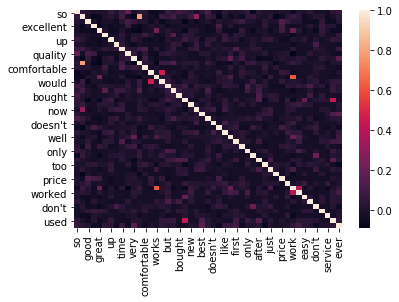

Baseline accuracy: 78.0%


In [5]:
for key in keywords:
    df[str(key)] = df.text.str.contains(str(key), case=False)

sns.heatmap(df[keywords].corr())
plt.show()

baseline_data = df[keywords]
baseline_target = df['Positive']

bnb = BernoulliNB()
bnb.fit(baseline_data, baseline_target)

baseline_predictions = bnb.predict(baseline_data)
baseline_accuracy = ((baseline_target == baseline_predictions).sum()/baseline_data.shape[0]) * 100
print('Baseline accuracy: {}%'.format(baseline_accuracy))

## Iteration 0

I am not convinced that finding the most popular words is the best way to gauge sentiment, especially when words like "not" and "no" show up in the top words. Context seems important when trying to understand the meaning of a particular word, and thus the review's overall sentiment, especially if a particular word is preceded by a negative word like "not" or "isn't".

In [6]:
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['text', 'Positive']
negators = ["n't ", " couldnt ", " dont ", " doesnt ", " isnt ", " not ", " no ", " wouldnt "]

for i, row in df.iterrows():
    for key in keywords:
        if str(key) in row['text'].lower():
            has_negative = False
            
            for negator in negators:
                if (negator + str(key)) in row['text'].lower():
                    has_negative = True
                    
            if has_negative:
                df.at[i, key] = False
                df.at[i, 'neg_' + str(key)] = True
            else: 
                df.at[i, key] = True
                df.at[i,'neg_' + key] = False
        else:
            df.at[i, key] = False
            df.at[i, 'neg_' + key] = False

df = df.loc[:, (df != False).any(axis=0)]
df.head()

,text,Positive,so,no,good,neg_good,excellent,great,neg_great,more,...,neg_work,worked,easy,better,don't,reception,neg_reception,service,used,ever
0,So there is no way for me to plug it in here i...,0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
new_keywords = np.delete(df.columns, [0, 1])
print('New Keywords: ')
print(new_keywords)

# sns.heatmap(df[new_keywords].corr())
# plt.show()

iter_0_data = df[new_keywords]
iter_0_target = df['Positive']

bnb = BernoulliNB()
bnb.fit(iter_0_data, iter_0_target)

iter_0_predictions = bnb.predict(iter_0_data)
iter_0_accuracy = ((iter_0_target == iter_0_predictions).sum()/iter_0_data.shape[0]) * 100
print('Iteration 0 accuracy: {}%'.format(iter_0_accuracy))

New Keywords: 
Index(['so', 'no', 'good', 'neg_good', 'excellent', 'great', 'neg_great',
       'more', 'up', 'neg_up', 'money', 'time', 'quality', 'very', 'neg_very',
       'not', 'comfortable', 'neg_comfortable', 'recommend', 'neg_recommend',
       'works', 'would', 'but', 'could', 'bought', 'use', 'neg_use', 'new',
       'neg_new', 'now', 'best', 'out', 'doesn't', 'product', 'like',
       'neg_like', 'well', 'first', 'nice', 'only', 'neg_only', 'buy',
       'neg_buy', 'after', 'too', 'neg_too', 'just', 'love', 'price', 'really',
       'work', 'neg_work', 'worked', 'easy', 'better', 'don't', 'reception',
       'neg_reception', 'service', 'used', 'ever'],
      dtype='object')
Iteration 0 accuracy: 78.7%


## Iteration 1

First, I will predict sentiment based on each review's count of 
1) the top 10 words in positive reviews, and 
2) the top 10 words in negative reviews

In [8]:
all_positive_reviews = df[df['Positive'] == 1].drop(['Positive'], axis=1)
all_negative_reviews = df[df['Positive'] == 0].drop(['Positive'], axis=1)

top_positive_counts = (all_positive_reviews==1).sum().nlargest(10)
top_negative_counts = (all_negative_reviews==1).sum().nlargest(10)

top_positive_words = top_positive_counts.index.values
top_negative_words = top_negative_counts.index.values

print('Top Positive Words:')
print(top_positive_words)

print('\nTop Negative Words:')
print(top_negative_words)

Top Positive Words:
['great' 'so' 'very' 'work' 'good' 'no' 'works' 'use' 'well' 'product']

Top Negative Words:
['no' 'not' 'so' 'use' 'ever' 'very' 'but' 'out' 'up' 'product']


Then, for each row, I find if that row 1) `has_top_word` for their sentiment category (i.e. positive review has top positive word), 2) `doesnt_have_other_top_word` for other sentiment category (i.e. positive review that does NOT have top negative word).

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


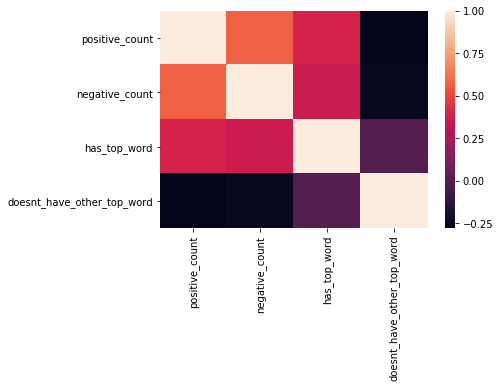

Iteration #1 accuracy: 80.2%


In [9]:
for i, row in df.iterrows():
    positive_count = 0
    negative_count = 0
    for positive_word in top_positive_words:
        if (row[positive_word] == True):
            positive_count += 1
    for negative_word in top_negative_words:
        if (row[negative_word] == True):
            negative_count += 1
    df.set_value(i, 'positive_count', positive_count)
    df.set_value(i, 'negative_count', negative_count)

top_positive_word = top_positive_words[0]
top_negative_word = top_negative_words[0]

def has_top_word(row):
    if row.loc['Positive'] == 1:
        return row.loc[top_positive_word] == True
    else:
        return row.loc[top_negative_word] == True

def does_not_have_other_top_word(row):
    if row.loc['Positive'] == 1:
        return row.loc[top_negative_word] == False
    else:
        return row.loc[top_positive_word] == False

df['has_top_word'] = [has_top_word(row) for (idx, row) in df.iterrows()]
df['doesnt_have_other_top_word'] = [does_not_have_other_top_word(row) for (idx, row) in df.iterrows()]

iter_1_keywords = np.append(new_keywords, ['positive_count', 'negative_count', 'has_top_word', 'doesnt_have_other_top_word'])
sns.heatmap(df[iter_1_keywords].corr())
plt.show()

iter_1_data = df[iter_1_keywords]
iter_1_target = df['Positive']

bnb = BernoulliNB()
bnb.fit(iter_1_data, iter_1_target)

iter_1_predictions = bnb.predict(iter_1_data)
iter_1_accuracy = ((iter_1_target == iter_1_predictions).sum()/iter_1_data.shape[0]) * 100
print('Iteration #1 accuracy: {}%'.format(iter_1_accuracy))

## Iteration 2

Next, I will calculate the character and sentence count of reviews.

In [10]:
for i, row in df.iterrows():
    positive_count = 0
    negative_count = 0
    for positive_word in top_positive_words:
        if (row[positive_word] == True):
            positive_count += 1
    for negative_word in top_negative_words:
        if (row[negative_word] == True):
            negative_count += 1
    df.set_value(i, 'positive_count', positive_count)
    df.set_value(i, 'negative_count', negative_count)

def get_sentence_count(row):
    sentence = row[1]['text'].lower()
    return len(re.split('(?<=[.!?]) +', sentence))

df['char_count'] = df['text'].str.len()
df['sentence_count'] = [get_sentence_count(row) for row in df.iterrows()]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


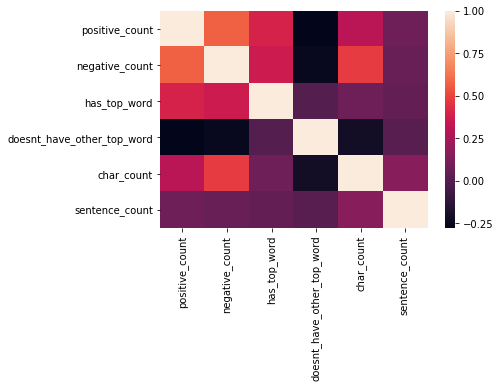

,so,no,good,neg_good,excellent,great,neg_great,more,up,neg_up,...,neg_reception,service,used,ever,positive_count,negative_count,has_top_word,doesnt_have_other_top_word,char_count,sentence_count
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,2.0,2.0,True,True,82,1
1,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,1.0,0.0,False,True,27,1
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,1.0,0.0,True,True,22,1
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,0.0,0.0,False,True,79,1
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,1.0,0.0,True,True,17,1


In [11]:
iter_2_keywords = np.append(iter_1_keywords, ['char_count', 'sentence_count'])
sns.heatmap(df[iter_2_keywords].corr())
plt.show()

iter_2_data = df[iter_2_keywords]
iter_2_target = df['Positive']

iter_2_data.head()

In [12]:
bnb = BernoulliNB()
bnb.fit(iter_2_data, iter_2_target)

iter_2_predictions = bnb.predict(iter_2_data)
iter_2_accuracy = ((iter_2_target == iter_2_predictions).sum()/iter_2_data.shape[0]) * 100
print('Iteration #2 accuracy: {}%'.format(iter_2_accuracy))

Iteration #2 accuracy: 80.2%


## Iteration 3

number of exclamation points
number of uppercase

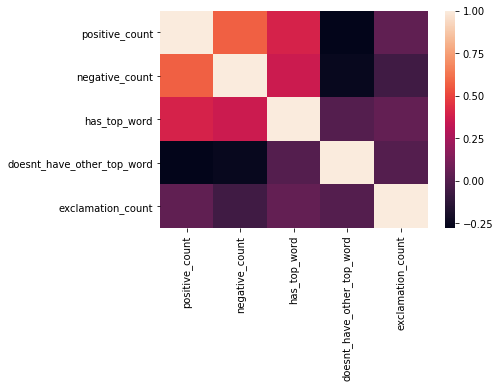

,so,no,good,neg_good,excellent,great,neg_great,more,up,neg_up,...,reception,neg_reception,service,used,ever,positive_count,negative_count,has_top_word,doesnt_have_other_top_word,exclamation_count
0,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,2.0,2.0,True,True,0
1,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,1.0,0.0,False,True,0
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,1.0,0.0,True,True,0
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,0.0,0.0,False,True,2
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,1.0,0.0,True,True,0


In [13]:
df['exclamation_count'] = df['text'].str.count('!')

iter_3_keywords = np.append(iter_1_keywords, ['exclamation_count'])
sns.heatmap(df[iter_3_keywords].corr())
plt.show()


iter_3_data = df[iter_3_keywords]
iter_3_target = df['Positive']

iter_3_data.head()

In [14]:
bnb = BernoulliNB()
bnb.fit(iter_3_data, iter_3_target)

iter_3_predictions = bnb.predict(iter_3_data)
iter_3_accuracy = ((iter_3_target == iter_3_predictions).sum()/iter_3_data.shape[0]) * 100
print('Iteration #3 accuracy: {}%'.format(iter_3_accuracy))

Iteration #3 accuracy: 80.30000000000001%


## Iteration 4



## Conclusion

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?